# Notes

Based on the features derived from our pretrained model, we are implementing a linear probing method for fine-tuning. In this example, our model's performance will be evaluated using a `leave-one-cohort-out (LOCO)` and `Cohort-to-Cohort (CTC)` Test approaches. The `LOCO` method involves systematically excluding each cohort from training and using it as a test set, thereby providing a comprehensive assessment of the model's generalization capabilities across different cohorts.

In [1]:
import sys
sys.path.insert(0, '/home/was966/Research/mims-responder/')
from responder.utils import plot_embed_with_label, score
from responder import PreTrainer, FineTuner, loadresponder

In [2]:
import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.5)

def onehot(S):
    assert type(S) == pd.Series, 'Input type should be pd.Series'
    dfd = pd.get_dummies(S, dummy_na=True)
    nanidx = dfd[dfd[np.nan]].index
    dfd.loc[nanidx, :] = np.nan
    dfd = dfd.drop(columns=[np.nan])*1.
    cols = dfd.sum().sort_values(ascending=False).index.tolist()
    dfd = dfd[cols]
    return dfd

In [3]:
# load the pretrained model as a feature extractor
pretrainer = loadresponder('./results/Pretrain_TCGA_tmb_20240116_220014/pretrainer.pt')
pretrainer.count_parameters()

80008

In [4]:
data_path = '/n/data1/hms/dbmi/zitnik/lab/users/was966/ITRP/TCGA-ITRP-GENESET-MERGE/1005/data'
df_label = pd.read_pickle(os.path.join(data_path, 'ALL.ITRP.PATIENT.TABLE'))
df_tpm = pd.read_pickle(os.path.join(data_path, 'ALL.ITRP.TPM.TABLE'))
df_tpm.shape, df_label.shape

skcm_idx = df_label.cancer_type=='SKCM'
skcm_df_tpm = df_tpm[skcm_idx]
skcm_df_label = df_label[skcm_idx]
skcm_df_task = onehot(skcm_df_label.response_label)

In [5]:
sidx = skcm_df_label.cohort != 'Hugo'
skcm_df_label = skcm_df_label[sidx]

skcm_df_tpm = skcm_df_tpm[sidx]
skcm_df_task = skcm_df_task[sidx]

In [6]:
size = skcm_df_label.groupby('cohort').size()
size = size.index + "\n(n = " + size.astype(str) + ")"

In [7]:
skcm_df_task.head()

,NR,R
Patient100_T_P,0.0,1.0
Patient102_T_P,0.0,1.0
Patient105_T_P,0.0,1.0
Patient106_T_P,0.0,1.0
Patient10_T_M,0.0,1.0


# Leave-one-cohort-out Test

In [8]:
cohort_list = ['Gide', 'Allen', 'MGH','Liu', 'Riaz']

params = {'mode': 'head',
            'lr': 1e-2,
            'device':'cuda',
            'weight_decay': 1e-4,
            'batch_size':16,
            'epochs': 20,
            'load_decoder':True,
            'task_dense_layer': [24], 
            'with_wandb': False,
            'verbose': True}


res = []
for cohort_name in cohort_list:
    test_idx = skcm_df_label[skcm_df_label.cohort == cohort_name].index
    train_idx = skcm_df_label[~skcm_df_label.index.isin(test_idx)].index
    
    train_X = skcm_df_tpm.loc[train_idx]
    train_y = skcm_df_task.loc[train_idx]
    test_X = skcm_df_tpm.loc[test_idx]    
    test_y = skcm_df_task.loc[test_idx]
    pretrainer = pretrainer.copy()
    finetuner = FineTuner(pretrainer, **params, work_dir= './results')

    finetuner.tune(df_tpm_train = train_X,
                   df_task_train = train_y,
                   task_name=cohort_name,
                   task_type='c',
                    )

    _, pred_trainy = finetuner.predict(train_X, batch_size = 16)
    _, pred_testy = finetuner.predict(test_X, batch_size = 16)
    s1 = score(train_y['R'], pred_trainy[1], pred_trainy.idxmax(axis=1))
    s2 = score(test_y['R'], pred_testy[1], pred_testy.idxmax(axis=1))
    dfs = pd.DataFrame([s1, s2], columns = ['ROC', 'PRC', 'F1', 'ACC'], index = ['Train', 'Test'])
    #finetuner.wandb.log({cohort_name:dfs.to_dict()})
    print('TEST-COHORT: %s, Training:%s, Test:%s' % (cohort_name, len(train_idx), len(test_idx)))
    print(dfs)

    res.append(dfs)
    if finetuner.with_wandb:
        finetuner.wandb.log(dfs.to_dict())
    finetuner.close()

df_loco = pd.concat(res).loc['Test']
df_loco.index = cohort_list
df_loco.index.name= 'Cohort'
df_loco.index = df_loco.index.map(size.to_dict())
df_loco_mean = df_loco.mean()
df_loco_mean.name = 'Model\n Average'
df_loco = df_loco.T

Load: inputencoder.embedder.abundance_embedder.layers.0.weight
Load: inputencoder.embedder.abundance_embedder.layers.0.bias
Load: inputencoder.encoder.layers.0.self_attn.in_proj_weight
Load: inputencoder.encoder.layers.0.self_attn.in_proj_bias
Load: inputencoder.encoder.layers.0.self_attn.out_proj.weight
Load: inputencoder.encoder.layers.0.self_attn.out_proj.bias
Load: inputencoder.encoder.layers.0.linear1.weight
Load: inputencoder.encoder.layers.0.linear1.bias
Load: inputencoder.encoder.layers.0.linear2.weight
Load: inputencoder.encoder.layers.0.linear2.bias
Load: inputencoder.encoder.layers.0.norm1.weight
Load: inputencoder.encoder.layers.0.norm1.bias
Load: inputencoder.encoder.layers.0.norm2.weight
Load: inputencoder.encoder.layers.0.norm2.bias
Load: latentprojector.genesetprojector.geneset_aggregator.aggregator.attention_weights.geneset_0
Load: latentprojector.genesetprojector.geneset_aggregator.aggregator.attention_weights.geneset_1
Load: latentprojector.genesetprojector.geneset_a

100%|##########| 5/5 [00:00<00:00, 15.61it/s]


TEST-COHORT: Gide, Training:235, Test:73
            ROC       PRC        F1       ACC
Train  0.906133  0.718514  0.800000  0.834043
Test   0.815909  0.847647  0.782609  0.726027
Saving the model to ./results/Finetune_Gide_20240116_231002/finetuner.pt
Load: inputencoder.embedder.abundance_embedder.layers.0.weight
Load: inputencoder.embedder.abundance_embedder.layers.0.bias
Load: inputencoder.encoder.layers.0.self_attn.in_proj_weight
Load: inputencoder.encoder.layers.0.self_attn.in_proj_bias
Load: inputencoder.encoder.layers.0.self_attn.out_proj.weight
Load: inputencoder.encoder.layers.0.self_attn.out_proj.bias
Load: inputencoder.encoder.layers.0.linear1.weight
Load: inputencoder.encoder.layers.0.linear1.bias
Load: inputencoder.encoder.layers.0.linear2.weight
Load: inputencoder.encoder.layers.0.linear2.bias
Load: inputencoder.encoder.layers.0.norm1.weight
Load: inputencoder.encoder.layers.0.norm1.bias
Load: inputencoder.encoder.layers.0.norm2.weight
Load: inputencoder.encoder.layers.0.n

100%|##########| 3/3 [00:00<00:00,  9.33it/s]


TEST-COHORT: Allen, Training:269, Test:39
            ROC       PRC        F1       ACC
Train  0.944890  0.858913  0.882883  0.903346
Test   0.656805  0.431934  0.437500  0.538462
Saving the model to ./results/Finetune_Allen_20240116_231030/finetuner.pt
Load: inputencoder.embedder.abundance_embedder.layers.0.weight
Load: inputencoder.embedder.abundance_embedder.layers.0.bias
Load: inputencoder.encoder.layers.0.self_attn.in_proj_weight
Load: inputencoder.encoder.layers.0.self_attn.in_proj_bias
Load: inputencoder.encoder.layers.0.self_attn.out_proj.weight
Load: inputencoder.encoder.layers.0.self_attn.out_proj.bias
Load: inputencoder.encoder.layers.0.linear1.weight
Load: inputencoder.encoder.layers.0.linear1.bias
Load: inputencoder.encoder.layers.0.linear2.weight
Load: inputencoder.encoder.layers.0.linear2.bias
Load: inputencoder.encoder.layers.0.norm1.weight
Load: inputencoder.encoder.layers.0.norm1.bias
Load: inputencoder.encoder.layers.0.norm2.weight
Load: inputencoder.encoder.layers.0

100%|##########| 3/3 [00:00<00:00, 10.55it/s]


TEST-COHORT: MGH, Training:270, Test:38
            ROC       PRC        F1       ACC
Train  0.943350  0.874072  0.864865  0.888889
Test   0.613095  0.420919  0.272727  0.578947
Saving the model to ./results/Finetune_MGH_20240116_231059/finetuner.pt
Load: inputencoder.embedder.abundance_embedder.layers.0.weight
Load: inputencoder.embedder.abundance_embedder.layers.0.bias
Load: inputencoder.encoder.layers.0.self_attn.in_proj_weight
Load: inputencoder.encoder.layers.0.self_attn.in_proj_bias
Load: inputencoder.encoder.layers.0.self_attn.out_proj.weight
Load: inputencoder.encoder.layers.0.self_attn.out_proj.bias
Load: inputencoder.encoder.layers.0.linear1.weight
Load: inputencoder.encoder.layers.0.linear1.bias
Load: inputencoder.encoder.layers.0.linear2.weight
Load: inputencoder.encoder.layers.0.linear2.bias
Load: inputencoder.encoder.layers.0.norm1.weight
Load: inputencoder.encoder.layers.0.norm1.bias
Load: inputencoder.encoder.layers.0.norm2.weight
Load: inputencoder.encoder.layers.0.nor

100%|##########| 7/7 [00:00<00:00, 15.68it/s]


TEST-COHORT: Liu, Training:201, Test:107
            ROC       PRC        F1       ACC
Train  0.955593  0.881429  0.875000  0.890547
Test   0.628234  0.498495  0.470588  0.579439
Saving the model to ./results/Finetune_Liu_20240116_231128/finetuner.pt
Load: inputencoder.embedder.abundance_embedder.layers.0.weight
Load: inputencoder.embedder.abundance_embedder.layers.0.bias
Load: inputencoder.encoder.layers.0.self_attn.in_proj_weight
Load: inputencoder.encoder.layers.0.self_attn.in_proj_bias
Load: inputencoder.encoder.layers.0.self_attn.out_proj.weight
Load: inputencoder.encoder.layers.0.self_attn.out_proj.bias
Load: inputencoder.encoder.layers.0.linear1.weight
Load: inputencoder.encoder.layers.0.linear1.bias
Load: inputencoder.encoder.layers.0.linear2.weight
Load: inputencoder.encoder.layers.0.linear2.bias
Load: inputencoder.encoder.layers.0.norm1.weight
Load: inputencoder.encoder.layers.0.norm1.bias
Load: inputencoder.encoder.layers.0.norm2.weight
Load: inputencoder.encoder.layers.0.no

100%|##########| 4/4 [00:00<00:00, 12.04it/s]


TEST-COHORT: Riaz, Training:257, Test:51
            ROC       PRC        F1       ACC
Train  0.965200  0.919285  0.889952  0.910506
Test   0.678049  0.522638  0.388889  0.568627
Saving the model to ./results/Finetune_Riaz_20240116_231152/finetuner.pt


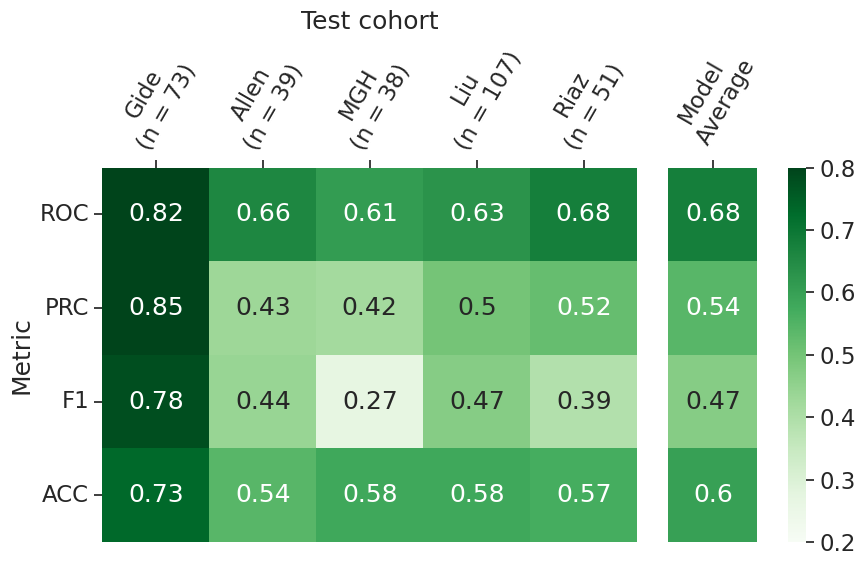

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9,6), 
                         gridspec_kw={'width_ratios': [6, 1, 0.2]},        
                         sharex=False, sharey=False)

ax1, ax2, ax3 = axes

sns.heatmap(df_loco.round(2), cmap = 'Greens',  ax = ax1, 
            annot=True, vmax=0.8, vmin = 0.2, cbar_ax = ax3)

sns.heatmap(df_loco_mean.round(2).to_frame(), cmap = 'Greens',  ax = ax2, 
            annot=True, vmax=0.8, vmin = 0.2, cbar=False)

ax2.set_ylabel("")
ax1.set_ylabel("Metric")

ax1.xaxis.tick_top() # x axis on top
ax1.xaxis.set_label_position('top')
ax1.set_xlabel("Test cohort")
ax1.tick_params(axis='x', labelrotation=60)

ax1.yaxis.tick_left() # x axis on top
ax1.tick_params(axis='y', labelrotation=0)

ax1.xaxis.tick_top() # x axis on top
ax1.xaxis.set_label_position('top')
ax1.set_xlabel("Test cohort")
ax1.tick_params(axis='x', labelrotation=60)

ax2.xaxis.tick_top() # x axis on top
ax2.tick_params(axis='x', labelrotation=60)
ax2.yaxis.set_visible(False)

fig.tight_layout()

## Cohort-to-Cohort Test

In [10]:

params = {'mode': 'head',
            'lr': 1e-2,
            'device':'cuda',
            'weight_decay': 1e-4,
            'batch_size':8,
            'epochs': 5,
            'task_dense_layer': [24], 
            'with_wandb': False,
            'verbose': True}

res = []
for cohort_name in cohort_list:
    train_idx = skcm_df_label[skcm_df_label.cohort == cohort_name].index
    test_idx = skcm_df_label[~skcm_df_label.index.isin(train_idx)].index
    
    train_X = skcm_df_tpm.loc[train_idx]
    train_y = skcm_df_task.loc[train_idx]
    test_X = skcm_df_tpm.loc[test_idx]    
    test_y = skcm_df_task.loc[test_idx]
    pretrainer = pretrainer.copy()
    finetuner = FineTuner(pretrainer, **params, work_dir= './results')

    finetuner.tune(df_tpm_train = train_X,
                   df_task_train = train_y,
                   task_name=cohort_name,
                   task_type='c',
                    )

    _, pred_trainy = finetuner.predict(train_X, batch_size = 16)
    _, pred_testy = finetuner.predict(test_X, batch_size = 16)

    df_pred = test_y[['R']].join(pred_testy[1].to_frame('prob.'))
    df_pred = df_pred.join(pred_testy.idxmax(axis=1).to_frame('pred_R'))
    df_pred = df_pred.join(skcm_df_label.cohort)
    df_test_res = df_pred.groupby('cohort').apply(lambda x:score(x['R'], x['prob.'], x['pred_R']))
    df_test_res = df_test_res.apply(pd.Series)
    df_test_res.columns = ['roc', 'prc', 'f1', 'acc']

    s1 = score(train_y['R'], pred_trainy[1], pred_trainy.idxmax(axis=1))
    df_train_res = pd.DataFrame(s1, index = ['roc', 'prc', 'f1', 'acc'], columns = [cohort_name]).T

    print(df_train_res)
    
    dfres = df_test_res._append(df_train_res)
    dfres = df_test_res._append(df_train_res)
    
    dfres['Test_cohort'] = dfres.index
    dfres['Train_cohort'] = cohort_name

    res.append(dfres)
    if finetuner.with_wandb:
        finetuner.wandb.log(dfs.to_dict())
    finetuner.close()

Load: inputencoder.embedder.abundance_embedder.layers.0.weight
Load: inputencoder.embedder.abundance_embedder.layers.0.bias
Load: inputencoder.encoder.layers.0.self_attn.in_proj_weight
Load: inputencoder.encoder.layers.0.self_attn.in_proj_bias
Load: inputencoder.encoder.layers.0.self_attn.out_proj.weight
Load: inputencoder.encoder.layers.0.self_attn.out_proj.bias
Load: inputencoder.encoder.layers.0.linear1.weight
Load: inputencoder.encoder.layers.0.linear1.bias
Load: inputencoder.encoder.layers.0.linear2.weight
Load: inputencoder.encoder.layers.0.linear2.bias
Load: inputencoder.encoder.layers.0.norm1.weight
Load: inputencoder.encoder.layers.0.norm1.bias
Load: inputencoder.encoder.layers.0.norm2.weight
Load: inputencoder.encoder.layers.0.norm2.bias
Load: latentprojector.genesetprojector.geneset_aggregator.aggregator.attention_weights.geneset_0
Load: latentprojector.genesetprojector.geneset_aggregator.aggregator.attention_weights.geneset_1
Load: latentprojector.genesetprojector.geneset_a

100%|##########| 15/15 [00:00<00:00, 23.57it/s]


           roc       prc        f1       acc
Gide  0.956818  0.964043  0.824742  0.767123
Saving the model to ./results/Finetune_Gide_20240116_231222/finetuner.pt
Load: inputencoder.embedder.abundance_embedder.layers.0.weight
Load: inputencoder.embedder.abundance_embedder.layers.0.bias
Load: inputencoder.encoder.layers.0.self_attn.in_proj_weight
Load: inputencoder.encoder.layers.0.self_attn.in_proj_bias
Load: inputencoder.encoder.layers.0.self_attn.out_proj.weight
Load: inputencoder.encoder.layers.0.self_attn.out_proj.bias
Load: inputencoder.encoder.layers.0.linear1.weight
Load: inputencoder.encoder.layers.0.linear1.bias
Load: inputencoder.encoder.layers.0.linear2.weight
Load: inputencoder.encoder.layers.0.linear2.bias
Load: inputencoder.encoder.layers.0.norm1.weight
Load: inputencoder.encoder.layers.0.norm1.bias
Load: inputencoder.encoder.layers.0.norm2.weight
Load: inputencoder.encoder.layers.0.norm2.bias
Load: latentprojector.genesetprojector.geneset_aggregator.aggregator.attention_

100%|##########| 17/17 [00:00<00:00, 24.98it/s]


            roc       prc    f1       acc
Allen  0.949704  0.924728  0.52  0.384615
Saving the model to ./results/Finetune_Allen_20240116_231228/finetuner.pt
Load: inputencoder.embedder.abundance_embedder.layers.0.weight
Load: inputencoder.embedder.abundance_embedder.layers.0.bias
Load: inputencoder.encoder.layers.0.self_attn.in_proj_weight
Load: inputencoder.encoder.layers.0.self_attn.in_proj_bias
Load: inputencoder.encoder.layers.0.self_attn.out_proj.weight
Load: inputencoder.encoder.layers.0.self_attn.out_proj.bias
Load: inputencoder.encoder.layers.0.linear1.weight
Load: inputencoder.encoder.layers.0.linear1.bias
Load: inputencoder.encoder.layers.0.linear2.weight
Load: inputencoder.encoder.layers.0.linear2.bias
Load: inputencoder.encoder.layers.0.norm1.weight
Load: inputencoder.encoder.layers.0.norm1.bias
Load: inputencoder.encoder.layers.0.norm2.weight
Load: inputencoder.encoder.layers.0.norm2.bias
Load: latentprojector.genesetprojector.geneset_aggregator.aggregator.attention_weigh

100%|##########| 17/17 [00:00<00:00, 26.09it/s]


          roc       prc        f1  acc
MGH  0.854167  0.718835  0.595745  0.5
Saving the model to ./results/Finetune_MGH_20240116_231233/finetuner.pt
Load: inputencoder.embedder.abundance_embedder.layers.0.weight
Load: inputencoder.embedder.abundance_embedder.layers.0.bias
Load: inputencoder.encoder.layers.0.self_attn.in_proj_weight
Load: inputencoder.encoder.layers.0.self_attn.in_proj_bias
Load: inputencoder.encoder.layers.0.self_attn.out_proj.weight
Load: inputencoder.encoder.layers.0.self_attn.out_proj.bias
Load: inputencoder.encoder.layers.0.linear1.weight
Load: inputencoder.encoder.layers.0.linear1.bias
Load: inputencoder.encoder.layers.0.linear2.weight
Load: inputencoder.encoder.layers.0.linear2.bias
Load: inputencoder.encoder.layers.0.norm1.weight
Load: inputencoder.encoder.layers.0.norm1.bias
Load: inputencoder.encoder.layers.0.norm2.weight
Load: inputencoder.encoder.layers.0.norm2.bias
Load: latentprojector.genesetprojector.geneset_aggregator.aggregator.attention_weights.genes

100%|##########| 13/13 [00:00<00:00, 19.74it/s]


          roc       prc        f1       acc
Liu  0.873984  0.686774  0.792079  0.803738
Saving the model to ./results/Finetune_Liu_20240116_231238/finetuner.pt
Load: inputencoder.embedder.abundance_embedder.layers.0.weight
Load: inputencoder.embedder.abundance_embedder.layers.0.bias
Load: inputencoder.encoder.layers.0.self_attn.in_proj_weight
Load: inputencoder.encoder.layers.0.self_attn.in_proj_bias
Load: inputencoder.encoder.layers.0.self_attn.out_proj.weight
Load: inputencoder.encoder.layers.0.self_attn.out_proj.bias
Load: inputencoder.encoder.layers.0.linear1.weight
Load: inputencoder.encoder.layers.0.linear1.bias
Load: inputencoder.encoder.layers.0.linear2.weight
Load: inputencoder.encoder.layers.0.linear2.bias
Load: inputencoder.encoder.layers.0.norm1.weight
Load: inputencoder.encoder.layers.0.norm1.bias
Load: inputencoder.encoder.layers.0.norm2.weight
Load: inputencoder.encoder.layers.0.norm2.bias
Load: latentprojector.genesetprojector.geneset_aggregator.aggregator.attention_wei

100%|##########| 17/17 [00:00<00:00, 26.80it/s]


           roc       prc        f1       acc
Riaz  0.963415  0.817744  0.512821  0.627451
Saving the model to ./results/Finetune_Riaz_20240116_231245/finetuner.pt


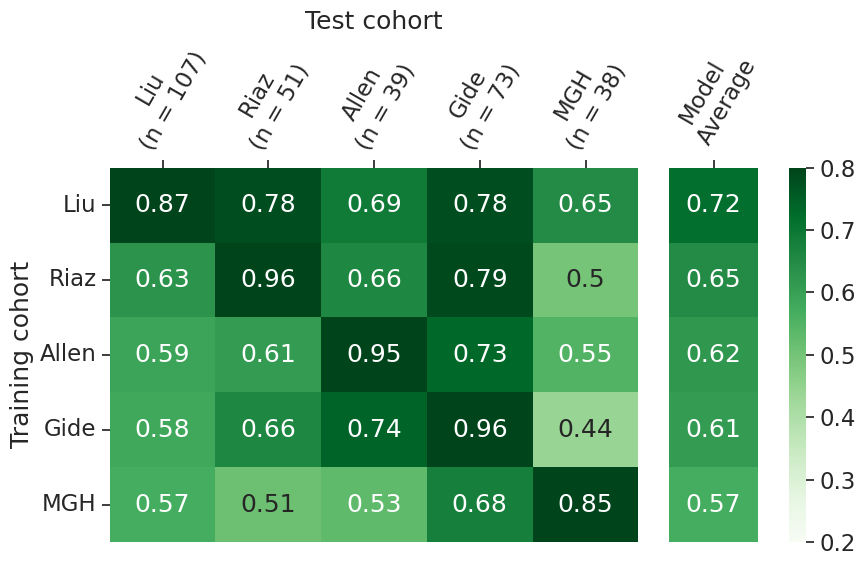

In [11]:
dfc2c = pd.concat(res).reset_index(drop=True)
dfc2c_roc = pd.pivot_table(data=dfc2c, index='Train_cohort', columns='Test_cohort', values='roc')

roc_mean = dfc2c_roc.copy()
np.fill_diagonal(roc_mean.values, np.nan)
roc_mean = roc_mean.mean(axis=1)
roc_mean.name = 'Model\n Average'
roc_mean = roc_mean.sort_values(ascending=False)

#map columns
dfc2c_roc = dfc2c_roc.loc[roc_mean.index][roc_mean.index]
dfc2c_roc.columns = dfc2c_roc.columns.map(size.to_dict())

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9,6), 
                         gridspec_kw={'width_ratios': [6, 1, 0.2]},
                         sharex=False, sharey=False)

ax1, ax2, ax3 = axes

sns.heatmap(dfc2c_roc.round(2), cmap = 'Greens',  ax = ax1, 
            annot=True, vmax=0.8, vmin = 0.2, cbar_ax = ax3)

sns.heatmap(roc_mean.round(2).to_frame(), cmap = 'Greens',  ax = ax2, 
            annot=True, vmax=0.8, vmin = 0.2, cbar=False)

ax2.set_ylabel("")
ax1.set_ylabel("Training cohort")

ax1.xaxis.tick_top() # x axis on top
ax1.xaxis.set_label_position('top')
ax1.set_xlabel("Test cohort")
ax1.tick_params(axis='x', labelrotation=60)

ax1.yaxis.tick_left() # x axis on top
ax1.tick_params(axis='y', labelrotation=0)

ax1.xaxis.tick_top() # x axis on top
ax1.xaxis.set_label_position('top')
ax1.set_xlabel("Test cohort")
ax1.tick_params(axis='x', labelrotation=60)

ax2.xaxis.tick_top() # x axis on top
ax2.tick_params(axis='x', labelrotation=60)
ax2.yaxis.set_visible(False)

fig.tight_layout()